### Détection d'objet :  
L'algorithme suivant permet d'entraîner un modèle pour comptabiliser des légos sur une image

# 1 - Import

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from time import time
import math
import openpyxl
from openpyxl.drawing.image import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from plot_keras_history import show_history, plot_history

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import SGD

# For normalization
import cv2
from skimage.exposure import match_histograms

os.environ["TF_KERAS"]='0'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


# 2 - Data Collection

In [2]:
image_dir = 'image_dir'
os.listdir(image_dir)

['20240206_140508.jpg',
 '20240206_140526.jpg',
 '20240206_140531.jpg',
 '20240206_140556.jpg',
 '20240206_140618.jpg']

## 3 - Functions

In [3]:
def tile_generator(image_path, tile_size, zoom):
    # Read the image
    img = cv2.imread(image_path)

    # Review tile_size taking into account the zoom
    int_tile_size = int(tile_size * zoom / 40)

    # Perform tiling
    for i in range(0, img.shape[0], int_tile_size):
        for j in range(0, img.shape[1], int_tile_size):
            tile = img[i:i+int_tile_size, j:j+int_tile_size]

            # Review image size to get tile 256x256
            tile = cv2.resize(tile, (tile_size, tile_size))

            yield tile

def tile_cutter(image_path, tile_dir, tile_size, zoom):
    # Create the tile directory if it doesn't exist
    os.makedirs(tile_dir, exist_ok=True)

    # Save each tile - oroginal image jpg
    for i, tile in tqdm(enumerate(tile_generator(image_path, tile_size, zoom))):
        img_tile = cv2.convertScaleAbs(tile, cv2.COLOR_BGR2RGB)  # Convert to RGB
        name = os.path.basename(image_path).replace('.jpg','')
        plt.imsave(os.path.join(tile_dir, f'{name}_{i}.png'), img_tile)

In [4]:
def tile_marker(image_path, color):
    # Dictionnaire des couleurs
    color_dic = {
        'red': [255, 0, 0],
        'blue': [0, 0, 255],
        'white': [255, 255, 255],
        'green': [0, 255, 0],
        'yellow': [0, 255, 255],
        'black' : [0, 0, 0]
                }
    
    # Lire l'image
    img = cv2.imread(image_path)

    # Vérifier si l'image a 3 canaux de couleur (couleur) ou 1 canal (niveau de gris)
    is_color = len(img.shape) == 3 and img.shape[2] == 3

    # Déterminer la couleur en fonction du mode de l'image (couleur ou niveau de gris)
    if is_color:
        color_value = np.array(color_dic[color][::-1])  # Inverser l'ordre pour passer de RGB à BGR
    else:
        color_value = np.array([color])

    # Ajouter une marge de la couleur spécifiée
    img[:20, :] = color_value
    img[-20:, :] = color_value
    img[:, :20] = color_value
    img[:, -20:] = color_value

    # Afficher l'image résultante
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #plt.show()
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

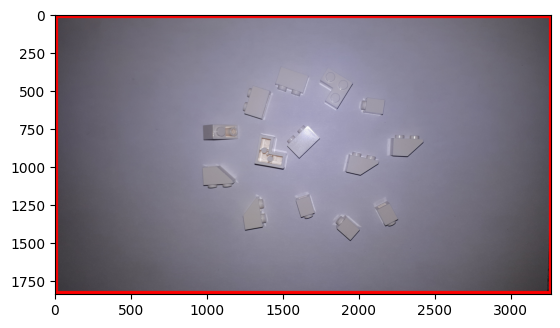

In [5]:
# Example usage
plt.imshow(tile_marker(str('image_dir/'+os.listdir(image_dir)[0]),'red'))

In [6]:
# take tiles and assemble them back into a reconstructed picture. Take into account the zoom
# as an ouput we have the thumbnail reconstructed
# VERIFIER LIGNE 13 !!!!
def tile_assembler(tile_dir, output_path, rows, columns, tile_width, zoom):
    int_tile_size = int(tile_width * zoom / 40)
    tile_width = int_tile_size
    img_assembled = np.zeros((rows * tile_width, columns * tile_width, 3), dtype=np.uint8)
    c = 0

    for i in range(rows):
        for j in range(columns):
            if c < len(os.listdir(tile_dir)):#108 :
                img_filename = f'20240206_140531_{c}.png'
                img_path = os.path.join(tile_dir, img_filename)

                # Read and resize each tile image
                tile_img = cv2.imread(img_path)
                tile_img = cv2.resize(tile_img, (int_tile_size, int_tile_size))

                if tile_img is None or tile_img.size == 0:
                    print(f"Error loading image: {img_path}")
                    continue

                tile_img = cv2.resize(tile_img, (tile_width, tile_width))

                # Calculate the position to paste each tile in the assembled image
                row_start = i * tile_width
                col_start = j * tile_width

                # Paste the tile into the assembled image
                img_assembled[row_start:row_start + tile_width, col_start:col_start + tile_width] = tile_img
                c += 1
            else:
                break

    # Save the assembled image
    cv2.imwrite(output_path, img_assembled)
    #return cv2.imread(output_path)

# 4 - tiling des images

In [7]:
%%time
# 4s
# On la coupe en tiles
#for img in image_dir:
img = '20240206_140508.jpg'
tile_cutter(str('image_dir/'+img), 'tile_dir', 256, 40)

104it [00:03, 27.00it/s]

CPU times: total: 3.34 s
Wall time: 3.86 s


In [8]:
len(os.listdir('tile_dir'))

104

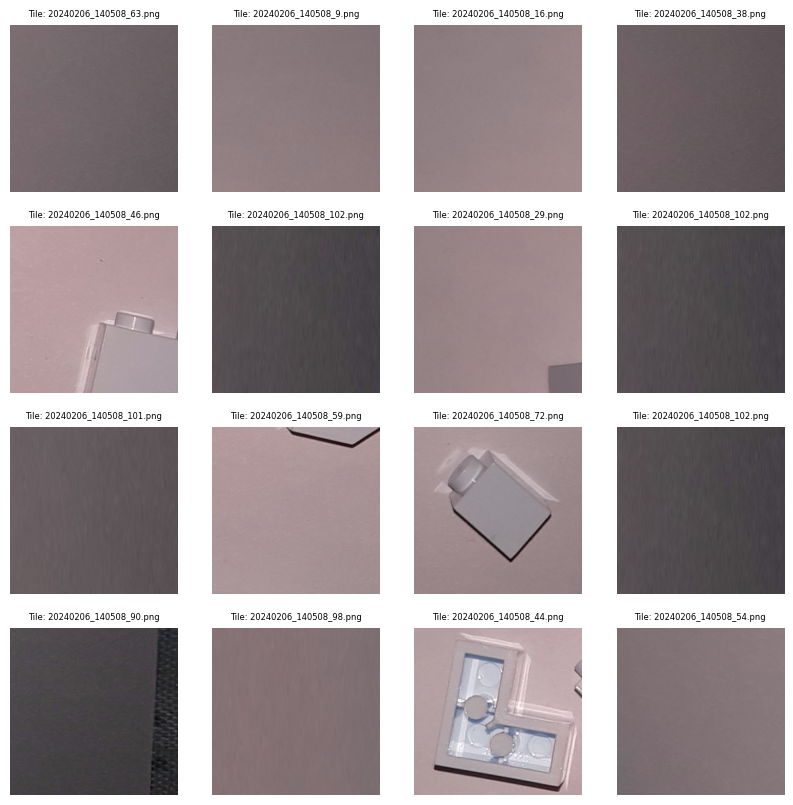

CPU times: total: 1.92 s
Wall time: 2.34 s


In [9]:
%%time
# Visualisons quelques tiles
plt.figure(figsize=(10, 10)) 

for i, img in enumerate(np.random.choice(os.listdir('tile_dir'),16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(plt.imread("tile_dir/"+img))
    plt.title(f"Tile: {img}",fontsize=6)
    plt.axis('off')

plt.show()

# 5 - Création du dataset d'entraînement

In [10]:
df = pd.DataFrame( {
    'image_path': [],
    'size' : [],
    'thumbnail': [],
    'label': []
})
df

,image_path,size,thumbnail,label


In [11]:
#for img in os.listdir('tile_dir'):
for img in os.listdir('tile_dir'):
    img_path = str('tile_dir/'+img)
    list_row = [img_path, os.path.getsize(img_path), 0, 0,]
    df.loc[len(df)] = list_row
df

,image_path,size,thumbnail,label
0,tile_dir/20240206_140508_0.png,47031,0,0
1,tile_dir/20240206_140508_1.png,44706,0,0
2,tile_dir/20240206_140508_10.png,41557,0,0
3,tile_dir/20240206_140508_100.png,26213,0,0
4,tile_dir/20240206_140508_101.png,28460,0,0
...,...,...,...,...
99,tile_dir/20240206_140508_95.png,24471,0,0
100,tile_dir/20240206_140508_96.png,22210,0,0
101,tile_dir/20240206_140508_97.png,22179,0,0
102,tile_dir/20240206_140508_98.png,23809,0,0


In [12]:
# On exporte le dataset au format xls
df.to_excel("dataset.xlsx", index=False)

### On va placer les thumbnails dans la colonne 'thumbnail'

In [13]:
# intanciation openpyxl du doc excel nommé dataset
try:
    # Essayez d'ouvrir le fichier Excel s'il existe déjà.
    file_path = "dataset.xlsx"
    workbook = openpyxl.load_workbook(file_path)
    print(f"Fichier Excel existant ouvert : {file_path}")
except FileNotFoundError:
    print("fichier non trouvé")

worksheet = workbook.active

Fichier Excel existant ouvert : dataset.xlsx


In [14]:
%%time
for idx, img_path in enumerate(df['image_path']):
    # Resize cells ligne idx+2
    worksheet.row_dimensions[idx+2].height = 50
    
    # Collage du thumbnail sur la troisième cellule de la ligne idx+2
    
    img = cv2.imread(df.iloc[idx,0])
    img = cv2.resize(img, (50, 50))
    img = cv2.imwrite(f'img{idx}.png', img)
     
    worksheet.add_image(Image(f'img{idx}.png'), anchor=f'C{idx+2}')#il faut que Image soit un objet openpyxl et non pas PIL
    
    # Sauvegarde du document xlsx
workbook.save('dataset.xlsx')
workbook.close()

CPU times: total: 641 ms
Wall time: 2.36 s


### On ouvre dataset.xlsx et on remplit la colonne label. On sauvegarde sous le nom dataset_train.xlsx

In [15]:
dataset_train = pd.read_excel("dataset_train.xlsx")
dataset_train.head()

,image_path,size,thumbnail,label
0,tile_dir/20240206_140508.jpg_45.png,76567,0,D
1,tile_dir/20240206_140508_45.png,76567,0,D
2,tile_dir/20240206_140508.jpg_44.png,73359,0,L
3,tile_dir/20240206_140508_44.png,73359,0,L
4,tile_dir/20240206_140508.jpg_90.png,53889,0,other


In [16]:
# laliste des label
dataset_train['label'].value_counts()

other    178
T         14
U         10
L          4
D          2
Name: label, dtype: int64

# 4 - Model preparation

### Pour classifier des images j'ai choisi d'utiliser le réseau de neurones VGG16 en mode transfer learning avec Data Augmentation.

In [17]:
# Step parameter definition
epochs_dic = {1:1, 2:15, 3:30}
batch_size_dic = {1:16, 2:32, 3:64}
optimizer_dic = {1:'Adam', 2:'rmsprop'}
label_dic = {1:['CC', 'EC', 'HGSC', 'LGSC', 'MC', 'other'], 2:['HGSC', 'Others']}
preprocessing_input_dic = {1:preprocess_input}

In [18]:
# Step class management (to be reviewed !)
# Number of classes
nb_lab = len(df['label'].unique())

# Class list
le = LabelEncoder()
le.fit_transform(df['label'])
list_lab = le.classes_

In [19]:
# Data augmentation function for train-val
def data_flow_fct(data, datagen, data_type=None, batch_size=None) :

    data_flow = datagen.flow_from_dataframe(data,
                                            #directory=dir_, # Pas besoin
                                            x_col='image_path',  # Utilisez 'image_path' comme colonne des chemins d'images
                                            y_col='label',#_name',
                                            weight_col=None,
                                            target_size=(256, 256),
                                            classes=None,
                                            class_mode='categorical',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=42,
                                            subset=data_type)
    return data_flow

In [20]:
# Data augmentation function
def datagen_trainer(preprocessing_input):
    datagen_train = ImageDataGenerator(
    #    featurewise_center=True,
    #    featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.25,# détermine le ration training/validation
        preprocessing_function=preprocessing_input)
    return datagen_train

def datagen_tester(preprocessing_input):
    datagen_test = ImageDataGenerator(
        validation_split=0,
        preprocessing_function=preprocess_input)
    return datagen_test

In [21]:
# Model creation function
def create_model_fct(nb_lab) :
    #weights_path = "/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5" # ATTENTION : activer hors connexion
    weights_path = 'imagenet'
    # Charger le modèle VGG16 pré-entraîné
    model0 = VGG16(include_top=False, weights=weights_path, input_shape=(256, 256, 3)) 
    
    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(nb_lab, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
       
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer_dic[1], metrics=["accuracy"])

    print(model.summary())
    
    return model

In [22]:
# Step flow definition
def define_flow(preprocessing_flow, batch_size_flow):
    # Data augmentation for train-val
    train_flow = data_flow_fct(data, datagen_trainer(preprocessing_flow), data_type='training',batch_size=batch_size_flow)
    val_flow = data_flow_fct(data, datagen_trainer(preprocessing_flow), data_type='validation',batch_size=batch_size_flow)
    test_flow = data_flow_fct(data, datagen_tester(preprocessing_flow), data_type=None, batch_size=1)
    return train_flow, val_flow, test_flow

In [23]:
# Step model creation and training
def model_creation_training(step,train_flow, val_flow,epochs_entry):
    # 4min35 for epochs = 1 and batch_size = 32
    # Model creation and training
    with tf.device('/gpu:1'):

        # Model creation
        print('1/3-Model creation')
        model = create_model_fct(nb_lab)

        # Call back creation
        print('2/3-Callbacks')
        model_save_path = f"model_best_weights_{step}.h5"
        checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
        es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
        callbacks_list = [checkpoint, es]

        # Training
        print('3/3-Training')
        history = model.fit(train_flow, epochs=epochs_entry, 
                            steps_per_epoch=len(train_flow),
                            callbacks=callbacks_list, 
                            validation_data=val_flow,
                            validation_steps=len(val_flow),
                            verbose=1)
    return model, history

In [24]:
# Step performance train_val
def performance_train_val(step,history, model, val_flow, batch_size_entry):
    # Performances
    print('1/6-val accuracy/epochs')
    show_history(history)
    plot_history(history, path=f"history_{step}.png")
    plt.close()

    print('2/6-predicting y_pred')
    #1min 28 for batch_size = 32
    y_pred = model.predict(val_flow, steps=len(val_flow), batch_size=batch_size_entry)

    print('3/6-getting y_val')
    nombre_total_val = len(val_flow) * batch_size_entry

    # Initialisation d'un tableau pour stocker les étiquettes réelles
    y_val = np.zeros((nombre_total_val, nb_lab))  

    # Itérer sur le générateur pour extraire les étiquettes réelles
    for i in range(len(val_flow)):
        _, batch_y_val = val_flow[i]  # Supposons que le générateur génère des paires (X_val, y_val)
        start_index = i * batch_size_dic[1]
        end_index = start_index + len(batch_y_val)
        y_val[start_index:end_index] = batch_y_val

    print('4/6-building the basic confusion matrix')
    # Obtenez les indices des classes prédites et réelles pour les échantillons disponibles
    y_val_indices = y_val.argmax(axis=1)[0:len(y_pred)]
    y_pred_indices = y_pred.argmax(axis=1)

    # Générer la matrice de confusion
    cm = confusion_matrix(y_val_indices, y_pred_indices)

    # Afficher la matrice de confusion
    print(cm)

    # Afficher le rapport de classification
    print("\n5/6-building the classification report")
    print(classification_report(y_val.argmax(axis=1)[0:len(y_pred)], y_pred.argmax(axis=1)))

    print('6/6-building the sns confusion matrix')
    # Finding the matching categorical labels for the numerical labels
    list_num_labels = sorted([x for x in set(y_val_indices)|set(y_pred_indices)])
    list_cat_labels = le.inverse_transform(list_num_labels)

    # Proceding with sns
    df_cm = pd.DataFrame(cm, index=list_cat_labels, columns=list_cat_labels)

    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(df_cm, annot=True, cmap="Blues")

    # Ajouter des étiquettes aux axes
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")

    plt.show()

In [25]:
# Step performance test
# Performance
def performance_test(step, model, test_flow):
    print('getting y_pred')
    # Testing on whole dataset
    #y_pred = model.predict(images_np)
    y_pred = model.predict(test_flow, steps=len(test_flow), batch_size=1)

    print('4/6-building the basic confusion matrix')
    # get y_val and y_pred
    y_pred_indices = y_pred.argmax(axis=1)
    y_pred_cat = le.inverse_transform(y_pred_indices)

    y_val_cat = data['label'][0:len(y_pred_cat)]

    # Générer la matrice de confusion
    cm = confusion_matrix(y_val_cat, y_pred_cat)

    # Afficher la matrice de confusion
    print(cm)

    # Afficher le rapport de classification
    print("\n5/6-building the classification report")
    print(classification_report(y_val_cat, y_pred_cat))

    print('6/6-building the sns confusion matrix')

    # Proceding with sns
    df_cm = pd.DataFrame(cm, index=label_dic[1], columns=label_dic[1])

    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(df_cm, annot=True, cmap="Blues")

    # Ajouter des étiquettes aux axes
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")
    
    # Sauvegardez l'image dans un fichier
    plt.savefig(f'confusion_matrix_{step}.png')

    plt.show()
    return y_val_cat, y_pred_cat, y_pred

# 5 - Etape 1 : Model training

### -Model_0 : Entraînement et test du modèle VGG sur les données d'entraînement

Step 1 : class management
Step 2 : flow definition
Found 78 validated image filenames belonging to 5 classes.
Found 26 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Step 3 : model creation and training
1/3-Model creation


C:\Users\John\Desktop\venv\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 104 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
C:\Users\John\Desktop\venv\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 104 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
C:\Users\John\Desktop\venv\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 104 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(





Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0  

C:\Users\John\Desktop\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - ETA: 0s - loss: 0.6664 - accuracy: 0.9359
Epoch 2: val_accuracy did not improve from 0.61538
5/5 [==============================] - 33s 7s/step - loss: 0.6664 - accuracy: 0.9359 - val_loss: 5.5360 - val_accuracy: 0.6154
Epoch 3/15
5/5 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.9359
Epoch 3: val_accuracy did not improve from 0.61538
5/5 [==============================] - 31s 6s/step - loss: 0.7333 - accuracy: 0.9359 - val_loss: 4.5211 - val_accuracy: 0.6154
Epoch 4/15
5/5 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.9359
Epoch 4: val_accuracy did not improve from 0.61538
5/5 [==============================] - 31s 7s/step - loss: 0.5328 - accuracy: 0.9359 - val_loss: 3.7837 - val_accuracy: 0.6154
Epoch 5/15
5/5 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.9231
Epoch 5: val_accuracy did not improve from 0.61538
5/5 [==============================] - 30s 6s/step - loss:

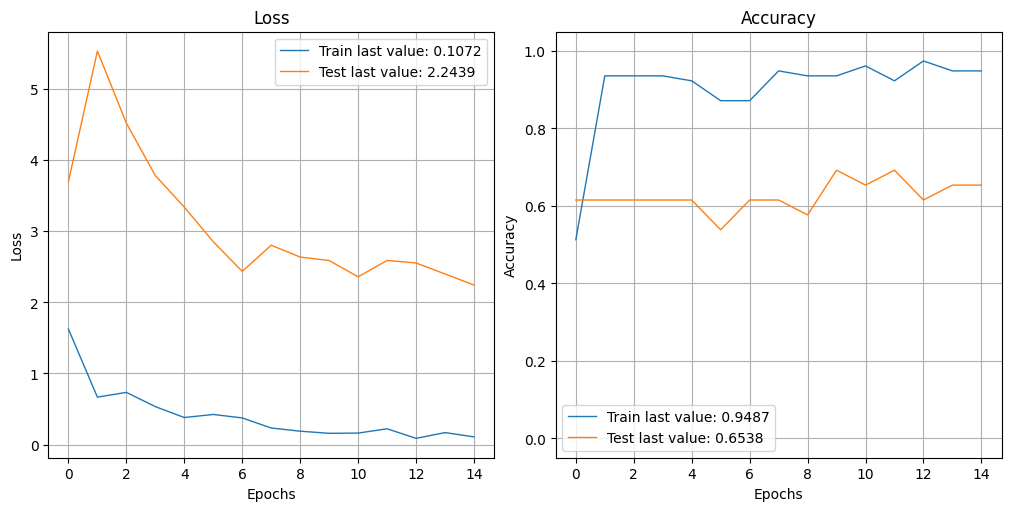

2/6-predicting y_pred
2/2 [==============================] - 8s 3s/step
3/6-getting y_val
4/6-building the basic confusion matrix
[[ 0  0  0  1  0]
 [ 0  0  0  0  2]
 [ 0  0  0  2  2]
 [ 0  0  0  2  1]
 [ 0  0  0  2 14]]

5/6-building the classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         4
           3       0.29      0.67      0.40         3
           4       0.74      0.88      0.80        16

    accuracy                           0.62        26
   macro avg       0.20      0.31      0.24        26
weighted avg       0.49      0.62      0.54        26

6/6-building the sns confusion matrix


C:\Users\John\Desktop\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\John\Desktop\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\John\Desktop\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


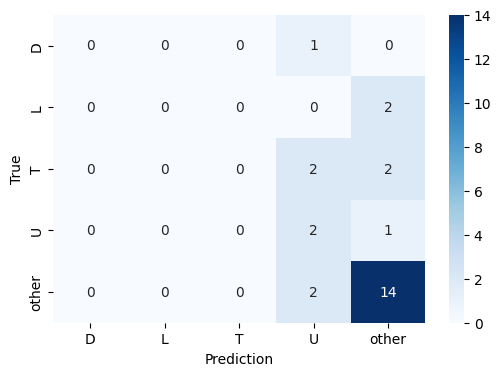

Step 6 : performance test
getting y_pred
104/104 [==============================] - 39s 376ms/step
4/6-building the basic confusion matrix
[[ 0  0  0  1  1]
 [ 0  0  0  1  3]
 [ 0  0  1  1 10]
 [ 0  0  0  2  6]
 [ 0  0  2 12 64]]

5/6-building the classification report
              precision    recall  f1-score   support

           D       0.00      0.00      0.00         2
           L       0.00      0.00      0.00         4
           T       0.33      0.08      0.13        12
           U       0.12      0.25      0.16         8
       other       0.76      0.82      0.79        78

    accuracy                           0.64       104
   macro avg       0.24      0.23      0.22       104
weighted avg       0.62      0.64      0.62       104

6/6-building the sns confusion matrix


C:\Users\John\Desktop\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\John\Desktop\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\John\Desktop\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


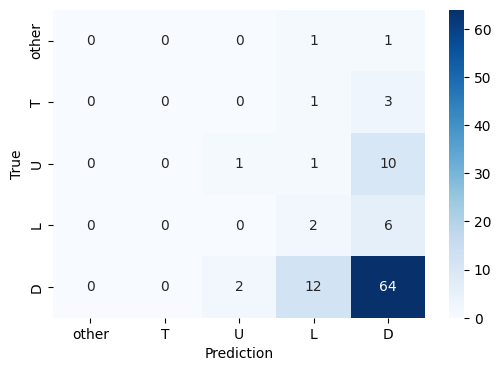

Step 7 : recording performance
CPU times: total: 31min 4s
Wall time: 8min 51s


,optimizer,method,test_accuracy,processing_time
0,rmsprop,preprocess_input,0.644231,530.984451


In [26]:
%%time
# 2min 30s
# Pipeline
# Step parameter definition
epochs_dic = {1:1, 2:15, 3:30}
batch_size_dic = {1:16, 2:32, 3:64}
optimizer_dic = {1:'Adam', 2:'rmsprop'}
label_dic = {1: ['other',
                'T',
                'U',
                'L',
                'D']}
preprocessing_input_dic = {1:preprocess_input}
step = 'step_0'
data = dataset_train

results = pd.DataFrame(columns=['optimizer','method','test_accuracy', 'processing_time'])
chrono = time()
for i in range(2,3):#rmsprop
    for j in range(1,2):#preprocess_input
#preprocess_input
        epochs_entry = epochs_dic[2]#15
        batch_size_entry = batch_size_dic[1]#16
        optimizer_entry = optimizer_dic[i]
        preprocessing_entry = preprocessing_input_dic[j]

        print('Step 1 : class management')
        # Step class management (to be reviewed !)
        # Number of classes
        nb_lab = len(data['label'].unique())

        # Class list
        le = LabelEncoder()
        le.fit_transform(data['label'])
        list_lab = le.classes_

        print('Step 2 : flow definition')
        # Step flow definition
        train_flow, val_flow, test_flow = define_flow(preprocessing_entry, batch_size_entry)

        print('Step 3 : model creation and training')
        # Step model creation and training
        model_0, history_0 = model_creation_training(step,train_flow, val_flow, epochs_entry)

        print('Step 4 : performance train_val')
        # Step performance train_val
        performance_train_val(step,history_0, model_0, val_flow, batch_size_entry)

        #print('Step 5 : préparation des images')
        # Step préparation des images (les images ne sont pas traitées !!)
        #images_np = image_prep_fct(data)
        #print(images_np.shape)

        print('Step 6 : performance test')
        # Step performance test
        #data=df.loc[df['is_tma']==False,:]
        #test_flow = data_flow_fct(df.loc[df['is_tma']==False,:], datagen_tester(preprocessing_entry), data_type=None, batch_size=1)
        y_val_cat, y_pred_cat, y_pred = performance_test(step, model_0, test_flow)

        print('Step 7 : recording performance')
        chrono = time() - chrono
        results.loc[len(results)] = [optimizer_entry, preprocessing_entry.__name__, accuracy_score(y_val_cat, y_pred_cat), chrono]
        chrono = time()
results

# 6 - Prediction sur une image

In [27]:
%%time
# 23s - 3min 7s
# on la découpe en tiles nommés 32035_thumbnails_{i}.png stockés dans un répertoire /kaggle/working/32035
tile_cutter(image_path=r'image_dir\20240206_140531.jpg', tile_dir='tile_dir_140531', tile_size=256, zoom=40)

104it [00:04, 24.10it/s]

CPU times: total: 3.47 s
Wall time: 4.32 s


In [28]:
# On va créer un df qui prend le chemin de chaque tile sur la colonne 'image_path'
df_tiles = pd.DataFrame()
df_tiles['image_path'] = os.listdir('tile_dir_140531')
df_tiles['image_path'] = list(map(lambda x : 'tile_dir_140531/'+x,df_tiles['image_path']))
df_tiles['label'] = 'a'

In [29]:
# On définit le X_test
X_test = df_tiles

In [30]:
%%time
# 7ms
# Transformer X_test en test_flow
test_flow = data_flow_fct(X_test, datagen_tester(preprocessing_entry), data_type=None, batch_size=1)

Found 104 validated image filenames belonging to 1 classes.
CPU times: total: 15.6 ms
Wall time: 28.4 ms


In [31]:
%%time
# 18s
# On prédit le test_flow => np array à 6 col (nb de labels)
y_pred = model_0.predict(test_flow)
y_pred[0:10]

104/104 [==============================] - 39s 378ms/step
CPU times: total: 1min 59s
Wall time: 39.6 s


array([[1.8163930e-03, 7.9555521e-03, 9.0665473e-03, 1.6307542e-02,
        9.6485394e-01],
       [2.6649577e-03, 8.6713247e-03, 1.4941968e-02, 1.5836712e-02,
        9.5788509e-01],
       [1.6395960e-02, 2.4574053e-02, 9.5950849e-02, 5.1300604e-02,
        8.1177849e-01],
       [1.3316594e-04, 1.8441457e-04, 9.7822258e-04, 2.2946604e-04,
        9.9847478e-01],
       [9.7808088e-06, 4.2329342e-05, 1.2318489e-04, 5.2449872e-05,
        9.9977225e-01],
       [9.2979502e-07, 6.5420086e-06, 1.2667003e-05, 1.2218784e-05,
        9.9996769e-01],
       [1.6768246e-07, 9.6215513e-07, 1.6002638e-06, 4.3490181e-06,
        9.9999297e-01],
       [1.3968939e-02, 3.1996012e-02, 7.1476184e-02, 5.9300635e-02,
        8.2325822e-01],
       [7.0895120e-03, 2.9138805e-02, 3.8461160e-02, 5.3353459e-02,
        8.7195718e-01],
       [2.3044981e-03, 9.0537192e-03, 1.0424893e-02, 2.1916803e-02,
        9.5629996e-01]], dtype=float32)

In [32]:
# On convertit le y_pred en une liste des labels catégoriels
y_pred_ = np.argmax(y_pred, axis=1)
y_pred_ = le.inverse_transform(y_pred_)
y_pred_[0:10]

array(['other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other'], dtype=object)

In [33]:
# On ajoute cette liste en colonne aux data d'entrée
data = df_tiles
data.loc[:,'pred'] = y_pred_

In [41]:
# Pour visualiser le résultat, d'abord on effectue un marking des tiles
for img_path, pred in zip(data['image_path'], data['pred']):
    #print(img_path,' ',pred)
    if pred == label_dic[1][0]:
        img = tile_marker(img_path, 'red')
        cv2.imwrite(img_path, img)
    elif pred == label_dic[1][1]:
        img = tile_marker(img_path, 'blue')
        cv2.imwrite(img_path, img)
    elif pred == label_dic[1][2]:
        img = tile_marker(img_path, 'yellow')
        cv2.imwrite(img_path, img)
    elif pred == label_dic[1][3]:
        img = tile_marker(img_path, 'green')
        cv2.imwrite(img_path, img)
    elif pred == label_dic[1][4]:
        img = tile_marker(img_path, 'white')
        cv2.imwrite(img_path, img)

In [42]:
%%time
#2s
# Puis on assemble les tiles marqués
tile_width = 256
zoom = 40
image_width, image_height, color_channels = (cv2.imread(r'image_dir\20240206_140531.jpg')).shape
rows = math.ceil(image_width / int(tile_width * zoom / 40))
columns = math.ceil(image_height / int(tile_width * zoom / 40))
tile_dir = 'tile_dir_140531'
output_path = r'20240206_140531_assembled.jpg'
tile_assembler(tile_dir, output_path, rows, columns, tile_width, zoom)

CPU times: total: 1.19 s
Wall time: 2.12 s


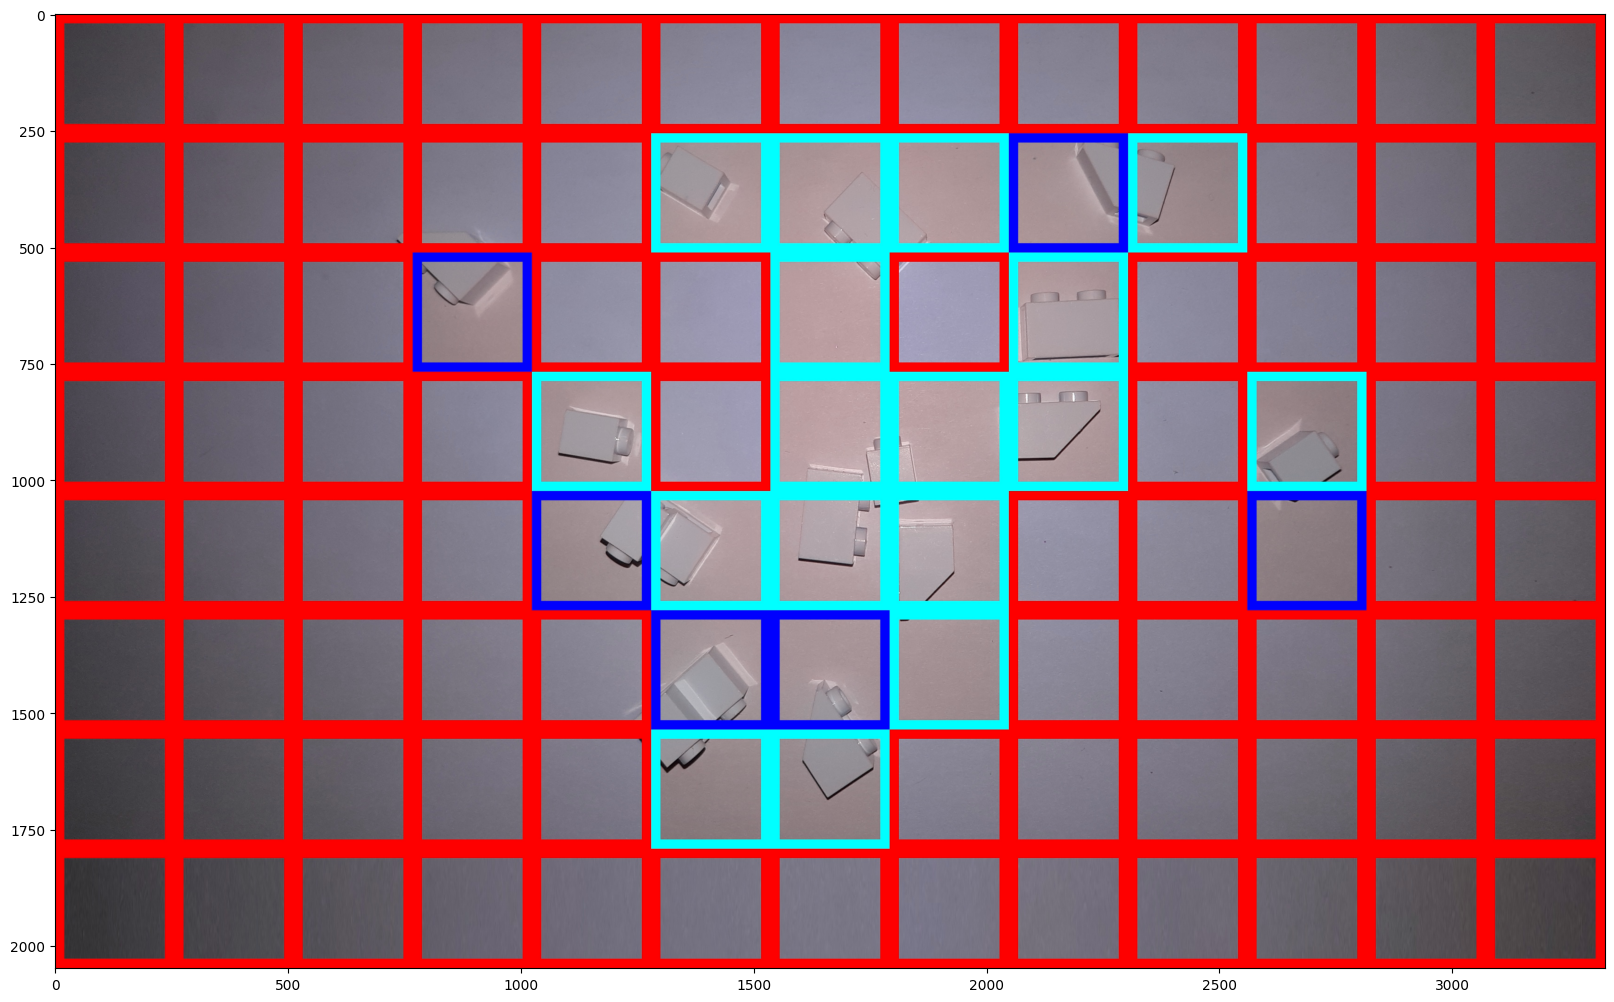

In [43]:
plt.figure(figsize=(20, 20))
plt.imshow(cv2.imread('20240206_140531_assembled.jpg'))

In [44]:
# On comptabilise le nombre de légo par type
data['pred'].value_counts()

other    81
U        17
T         6
Name: pred, dtype: int64

# 7 - Généralisation

In [38]:
%%time
# 37min 31s
# pour tile_size=512, zoom=38
# Pour chaque image du df on effectue un tiling. Les tiles sont stockées dans des répertoires au nom de l'image_id'
for img_path, zoom, img_id in zip(df['image_path'], df['zoom'], df['image_id']):
    tile_dir = '/kaggle/working/'+ str(img_id)
    tile_cutter(image_path=img_path, tile_dir=tile_dir, tile_size=512, zoom=20)

KeyError: 'zoom'

In [39]:
%%time
# Pour chaque sac de tiles on effectue une prediction qu'on stocke dans une colonne 'pred' de df
for tile_dir in list(map(lambda x : '/kaggle/working/'+ str(x), df['image_id'])):
    print('1 - On va créer un df qui prend le chemin de chaque tile sur la colonne image_path')
    df_ = pd.DataFrame()
    df_['image_path'] = os.listdir(tile_dir)
    df_['image_path'] = list(map(lambda x : tile_dir + '/'+ x, df_['image_path']))
    df_['label'] = 'a'
    print('2 - Ensuite on va créer le test_flow')
    test_flow = data_flow_fct(df_, datagen_tester(preprocessing_entry), data_type=None, batch_size=1)
    print('3 - On prédit le test_flow')
    y_pred = model_0.predict(test_flow)
    print('4 - On convertit le np.array y_pred en un liste des labels catgoriels')
    y_pred= le.inverse_transform(np.argmax(y_pred, axis=1))
    print('5 - On met ce y_pred dans la colonne label de df_')
    df_['label'] = y_pred
    print('6 - On enregistre la prédiction majoritaire dans une variable label')
    label = df_['label'].value_counts().index[1]
    print('7 - On attribue cette label à l\'image_id dans la colonne pred du df de départ')
    df.loc[df['image_id']==os.path.basename(tile_dir), 'pred'] = label

KeyError: 'image_id'

# 8 - Performance

In [40]:
step = '8_performance'
y_val_cat = df['label']
y_pred_cat = df['pred']

# Générer la matrice de confusion
cm = confusion_matrix(y_val_cat, y_pred_cat)

# Afficher la matrice de confusion
print(cm)

# Afficher le rapport de classification
print("\n5/6-building the classification report")
print(classification_report(y_val_cat, y_pred_cat))

print('6/6-building the sns confusion matrix')

# Proceding with sns
df_cm = pd.DataFrame(cm, index=label_dic[1], columns=label_dic[1])

plt.figure(figsize=(6, 4))
ax = sns.heatmap(df_cm, annot=True, cmap="Blues")

# Ajouter des étiquettes aux axes
ax.set_xlabel("Prediction")
ax.set_ylabel("True")

# Sauvegardez l'image dans un fichier
plt.savefig(f'confusion_matrix_{step}.png')

KeyError: 'pred'

In [ ]:
plt.show(plt.imread('/kaggle/working/confusion_matrix_8_performance.png'))